In [1]:
import numpy as np
import gpflow
from tqdm import tqdm
import matplotlib.pyplot as plt

def generate_data_points(num_points):
    np.random.seed(42)
    X = np.linspace(0, num_points, num_points).reshape(-1, 1)
    return X

# 线性变点函数
def linear_changepoint(X):
    num_points = len(X)
    mid_point = num_points // 3
    Y = np.zeros_like(X)
    Y[:mid_point] = 0
    Y[mid_point:num_points - mid_point] = 0.1 * (X[mid_point:num_points - mid_point] - mid_point)
    Y[num_points - mid_point:] = 0.1 * (num_points - mid_point - X[num_points - mid_point:])
    Y += 0.0001 * np.random.randn(*X.shape)
    return Y

# 正弦变点函数
def sinusoidal_changepoint(X):
    num_points = len(X)
    mid_point = num_points // 3
    Y = np.zeros_like(X)
    Y[:mid_point] = 0
    Y[mid_point:num_points - mid_point] = np.sin((X[mid_point:num_points - mid_point] - mid_point) * 0.1 * np.pi)
    Y[num_points - mid_point:] = 0
    Y += 0.0001 * np.random.randn(*X.shape)
    return Y

# 阶跃变点函数
def step_changepoint(X):
    num_points = len(X)
    mid_point = num_points // 3
    Y = np.zeros_like(X)
    Y[:mid_point] = 0
    Y[mid_point:num_points - mid_point] = 1
    Y[num_points - mid_point:] = 0
    Y += 0.0001 * np.random.randn(*X.shape)
    return Y

# 多项式变点函数
def polynomial_changepoint(X):
    num_points = len(X)
    mid_point = num_points // 3
    Y = np.zeros_like(X)
    Y[:mid_point] = 0
    Y[mid_point:num_points - mid_point] = 0.001 * (X[mid_point:num_points - mid_point] - mid_point) ** 2
    Y[num_points - mid_point:] = 0
    Y += 0.0001 * np.random.randn(*X.shape)
    return Y

num_points = 50
X = generate_data_points(num_points)

# 生成不同变点模式的数据


In [2]:
# # Test Case

# k1 = gpflow.kernels.Matern32()
# k2 = gpflow.kernels.Matern32()
# x = X[90 : 110]
# y = Y[90 : 110]

# # 实例化变点核函数
# changepoint_kernel = gpflow.kernels.ChangePoints([k1, k2], locations=[100.67114093959732], steepness=steepness)
# gpr_model_base = gpflow.models.GPR(data=(x, y), kernel=changepoint_kernel, mean_function=None)
# opt = gpflow.optimizers.Scipy()
# opt.minimize(gpr_model_base.training_loss, variables=gpr_model_base.trainable_variables)
# nlml_C = gpr_model_base.training_loss().numpy()

# kernel = gpflow.kernels.Matern32()
# model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
# optimizer = gpflow.optimizers.Scipy()
# optimizer.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
# nlml_M = model.training_loss().numpy()

# print(f"包含变点核函数的nlml: {nlml_C}")
# print(f"不包含变点核函数的nlml: {nlml_M}")

# v = 1 - 1 /(1 + np.exp(-(nlml_C - nlml_M)))
# loc = changepoint_kernel.locations.numpy()[0]

# print(f"变点得分：{v}")
# print(loc)
# print(f"变点位置：{loc / 150}")

0


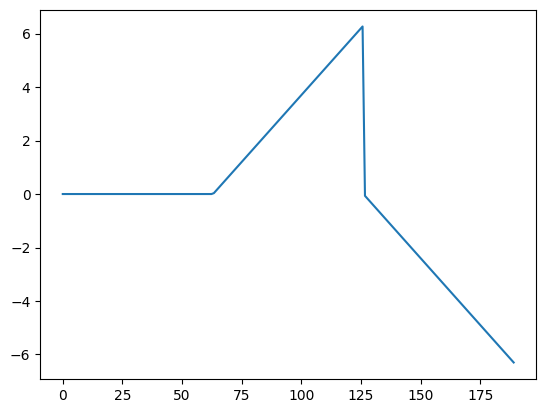

[(0, 63), (64, 83), (84, 109), (110, 125), (126, 151), (152, 172), (173, 189)]
1


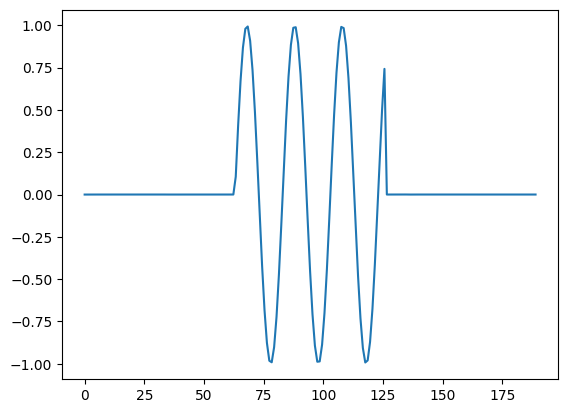

[(0, 63), (64, 72), (73, 82), (83, 92), (93, 102), (103, 112), (113, 125), (126, 189)]
2


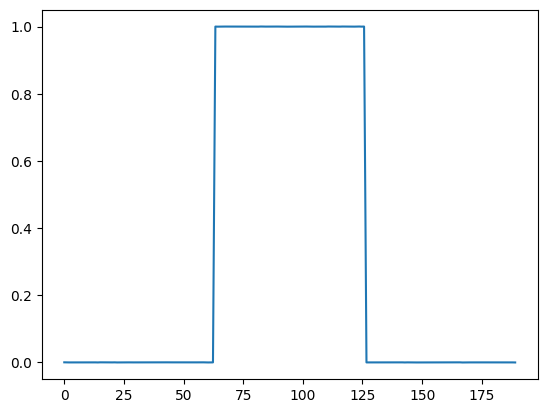

[(0, 62), (63, 113), (114, 119), (120, 125), (126, 189)]
3


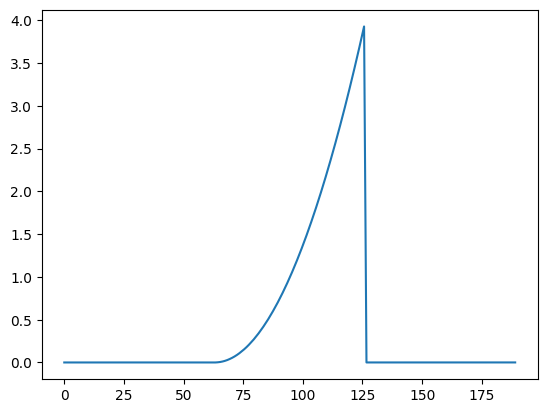

[(0, 64), (65, 71), (72, 78), (79, 87), (88, 94), (95, 102), (103, 112), (113, 119), (120, 125), (126, 189)]


In [3]:
lbw = 21
l_max, mu = 21, 0.9
l_max, mu = 63, 0.99
l_min = 5
steepness = 1

def get_segment_points(Y: np.ndarray, l_max: int, mu: int, l_min: int=5, lbw: int=21, steepness: int=1) -> list[tuple]:
    """
    使用高斯过程和变点检测算法在时间序列数据中寻找分段点。

    参数：
    Y (np.ndarray): 输入的时间序列数据。
    l_max (int): 允许的最大段长度。
    mu (int): 用于判断变点的阈值。
    l_min (int, 可选): 允许的最小段长度，默认值为5。
    lbw (int, 可选): 滑动窗口的长度，默认值为21。
    steepness (int, 可选): 变点核函数的陡峭度，默认值为1。

    返回：
    list[tuple]: 找到的分段点列表，每个分段点表示为 (start, end) 的元组。
    """
    
    loc, v = None, 0
    t, t_1 = len(Y), len(Y)
    X = np.arange(len(Y)).reshape(-1, 1).astype(float)
    R = []
    while t >= 0:
        if t - lbw < 0:
            break

        x = X[t - lbw : t]
        y = Y[t - lbw : t]

        location = x[int((lbw) // 2)][0]

        kernel = gpflow.kernels.Matern32()
        k1 = gpflow.kernels.Matern32()
        k2 = gpflow.kernels.Matern32()
        
        # 初始化一个高斯变点模型
        changepoint_kernel = gpflow.kernels.ChangePoints(
            [k1, k2], locations=[location], steepness=steepness
        )
        gpr_model_base = gpflow.models.GPR(
            data=(x, y), kernel=changepoint_kernel, mean_function=None
        )
        opt = gpflow.optimizers.Scipy()
        opt.minimize(
            gpr_model_base.training_loss, variables=gpr_model_base.trainable_variables
        )
        nlml_C = gpr_model_base.training_loss().numpy()

        # 初始化一个高斯过程模型
        kernel = gpflow.kernels.Matern32()
        model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
        optimizer = gpflow.optimizers.Scipy()
        optimizer.minimize(
            model.training_loss, model.trainable_variables, options=dict(maxiter=100)
        )
        nlml_M = model.training_loss().numpy()

        prev_loc = loc
        loc = changepoint_kernel.locations.numpy()[0]
        if loc < x[-1][0] and loc > x[0][0]:
            # 成功拟合
            L_C = np.exp(-nlml_C)
            L_M = np.exp(-nlml_M)
            v = L_C / (L_C + L_M)
        else:
            if prev_loc is not None:
                loc = prev_loc - 1
            else:
                loc = x[-1][0] - 1  # 如果是第一次拟合失败，使用当前窗口的最后一个时间点


        if v > mu:
            t_0 = int(np.ceil(loc))
            if t_1 - t_0 >= l_min:
                R.append((t_0, t_1))
                t_1 = t_0 - 1
            t = int(np.floor(loc)) - 1
        else:
            t = t - 1
            if t_1 - t > l_max:
                t = t_1 - l_max
            if t_1 - t == l_max:
                R.append((t, t_1))
                t_1 = t
    R.append((0, R[-1][0] - 1))
    R = list(reversed(R))
    return R


X = generate_data_points(63 * 3)
Y_1 = linear_changepoint(X)
Y_2 = sinusoidal_changepoint(X)
Y_3 = step_changepoint(X)
Y_4 = polynomial_changepoint(X)

for i, Y in enumerate((Y_1, Y_2, Y_3, Y_4)):
    print(i)
    plt.plot(X, Y)
    plt.show()
    R = get_segment_points(Y, l_max=l_max, mu=mu, l_min=l_min)
    print(R)
    